**GRAPH NETWORK OF THE FIRST THREE BOOKS OF "The Wheel of Time"**


This code buils and analyzes a graph network of the first three books of the series "The Wheel of Time", to understand the evolving relevance of characters across them. For each book, it identifies character mentions, extracts relationships between characters appearing within a short window of text, and builds a graph network based on these relationships. It also calculates the degree centrality, betweeness and closeteness, for each character. Finally, it compiles the degree centrality data for the top overall characters across all books and generates a line graph showing how the caracthers importance changes throught the three books.
IMPORTANT:The html graph visualization was specically build for Windows, so it might need to be change in order to run on macOS or Linux.

Load Books

In [79]:
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

In [80]:
NER = spacy.load("en_core_web_sm")

In [81]:
import os

#Loading books
books = [b for b in os.scandir('data') if '.txt' in b.name]
books

[<DirEntry 'Robert Jordan - The Wheel of Time 01 - Eye of the world.txt'>,
 <DirEntry 'Robert Jordan - The Wheel of Time 02 - The Great Hunt.txt'>,
 <DirEntry 'Robert Jordan - The Wheel of Time 03 - The Dragon Reborn.txt'>]

In [82]:
#Reading books
NER.max_length = 2000000
book = books[1]
book_txt = open(book, encoding='latin1').read()
book_doc = NER(book_txt)

displacy.render(book_doc[0:1000], style="ent", jupyter=True)

Character Names


In [83]:
import re

character_df = pd.read_csv("characters.csv", encoding="latin1")
character_df = pd.read_csv("characters.csv", encoding="latin1")
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

pd.set_option('display.max_rows', None)
print(character_df)

                     book                          character  \
0    The Eye of the World                      Abell Cauthon   
1    The Eye of the World                      Ackley Farren   
2    The Eye of the World                       Adan alCaar   
3    The Eye of the World                       Adora Aybara   
4    The Eye of the World            Aemon al Caar al Thorin   
5    The Eye of the World                      Agelmar Jagad   
6    The Eye of the World                             Aginor   
7    The Eye of the World                alAkir Mandragoran   
8    The Eye of the World                      Master alDai   
9    The Eye of the World                  Mistress alDonel   
10   The Eye of the World                             Aldieb   
11   The Eye of the World                      Alene alVere   
12   The Eye of the World                         Almen Bunt   
13   The Eye of the World                        Alpert Mull   
14   The Eye of the World               

Character Names per Sentence

In [84]:
sent_entity_df = []

#Loop sentences and store entities names for each one
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
sent_entity_df = pd.DataFrame(sent_entity_df)

In [85]:
#Filter ou non-character entities
def filter_characters(ent_list, character_df):
    return[ent for ent in ent_list
           if ent in list(character_df.character)
           or ent in list(character_df.character_firstname)]

#Test filter characters function
filter_characters(["Dragon","Ara","hundred"], character_df)

['Dragon', 'Ara']

In [86]:
#Take out non-characters
sent_entity_df['entities'] = sent_entity_df['entities'].apply(lambda x: filter_characters(x, character_df))
#Take out sentences without characters
sent_entity_df = sent_entity_df[sent_entity_df['entities'].apply(lambda x: x != [])]
#Take out repetitive characters (ex: Mavra and Mavra Mallen)
sent_entity_df['entities'] = sent_entity_df['entities'].apply(lambda x: [item.split()[0] for item in x])
sent_entity_df.head(20)

,sentence,entities
4,"(The, Dragon, shall, be, Reborn, ,, and, there...",[Dragon]
10,"(In, the, Shadow, \n\n , The, man, who, ...",[Bors]
20,"(Where, the, chamber, was, ,, the, man, who, c...",[Bors]
67,"(And, unless, the, man, who, called, himself, ...",[Bors]
72,"(The, Shienaran, wasted, little, time, on, the...",[Bors]
73,"(The, man, who, called, himself, Bors, snorted...",[Bors]
87,"(The, man, who, called, himself, Bors, did, no...",[Bors]
102,"(Even, the, man, who, called, himself, Bors, ....",[Bors]
128,"(Rage, filled, the, man, who, called, himself,...",[Bors]
132,"(Without, waiting, to, see, if, anyone, else, ...",[Bors]


Create Relations


In [87]:
#Find relations between characters in paragraphs
window_size = 5 #Size of paragraph when looking out for names
relationships = []

for i in range(sent_entity_df.index[-1]):
    end_i = min(i+5, sent_entity_df.index[-1])
    char_list = sum((sent_entity_df.loc[i: end_i].entities), [])

    #Remove relations with itself
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [88]:
#Creating relations dataframe
relationships_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)

#Sort a<-b and a->b cases
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns = relationships_df.columns)
relationships_df

#Attributing values to relations
relationships_df["value"] = 1
relationships_df = relationships_df.groupby(["source", "target"], sort= False, as_index=False).sum()
relationships_df.head(10)

,source,target,value
0,Bors,Dragon,3
1,Moiraine,Rand,279
2,Rand,Two,80
3,Perrin,Rand,514
4,Egwene,Nynaeve,955
5,Amalisa,Moiraine,42
6,Elansu,Rand,2
7,Amyrlin,Perrin,9
8,Agelmar,Rand,124
9,Agelmar,Ronan,6


Graph Analysis and Visualization

In [89]:
#Create graph
G = nx.from_pandas_edgelist(relationships_df,
                            source='source',
                            target='target',
                            edge_attr='value',
                            create_using=nx.Graph())


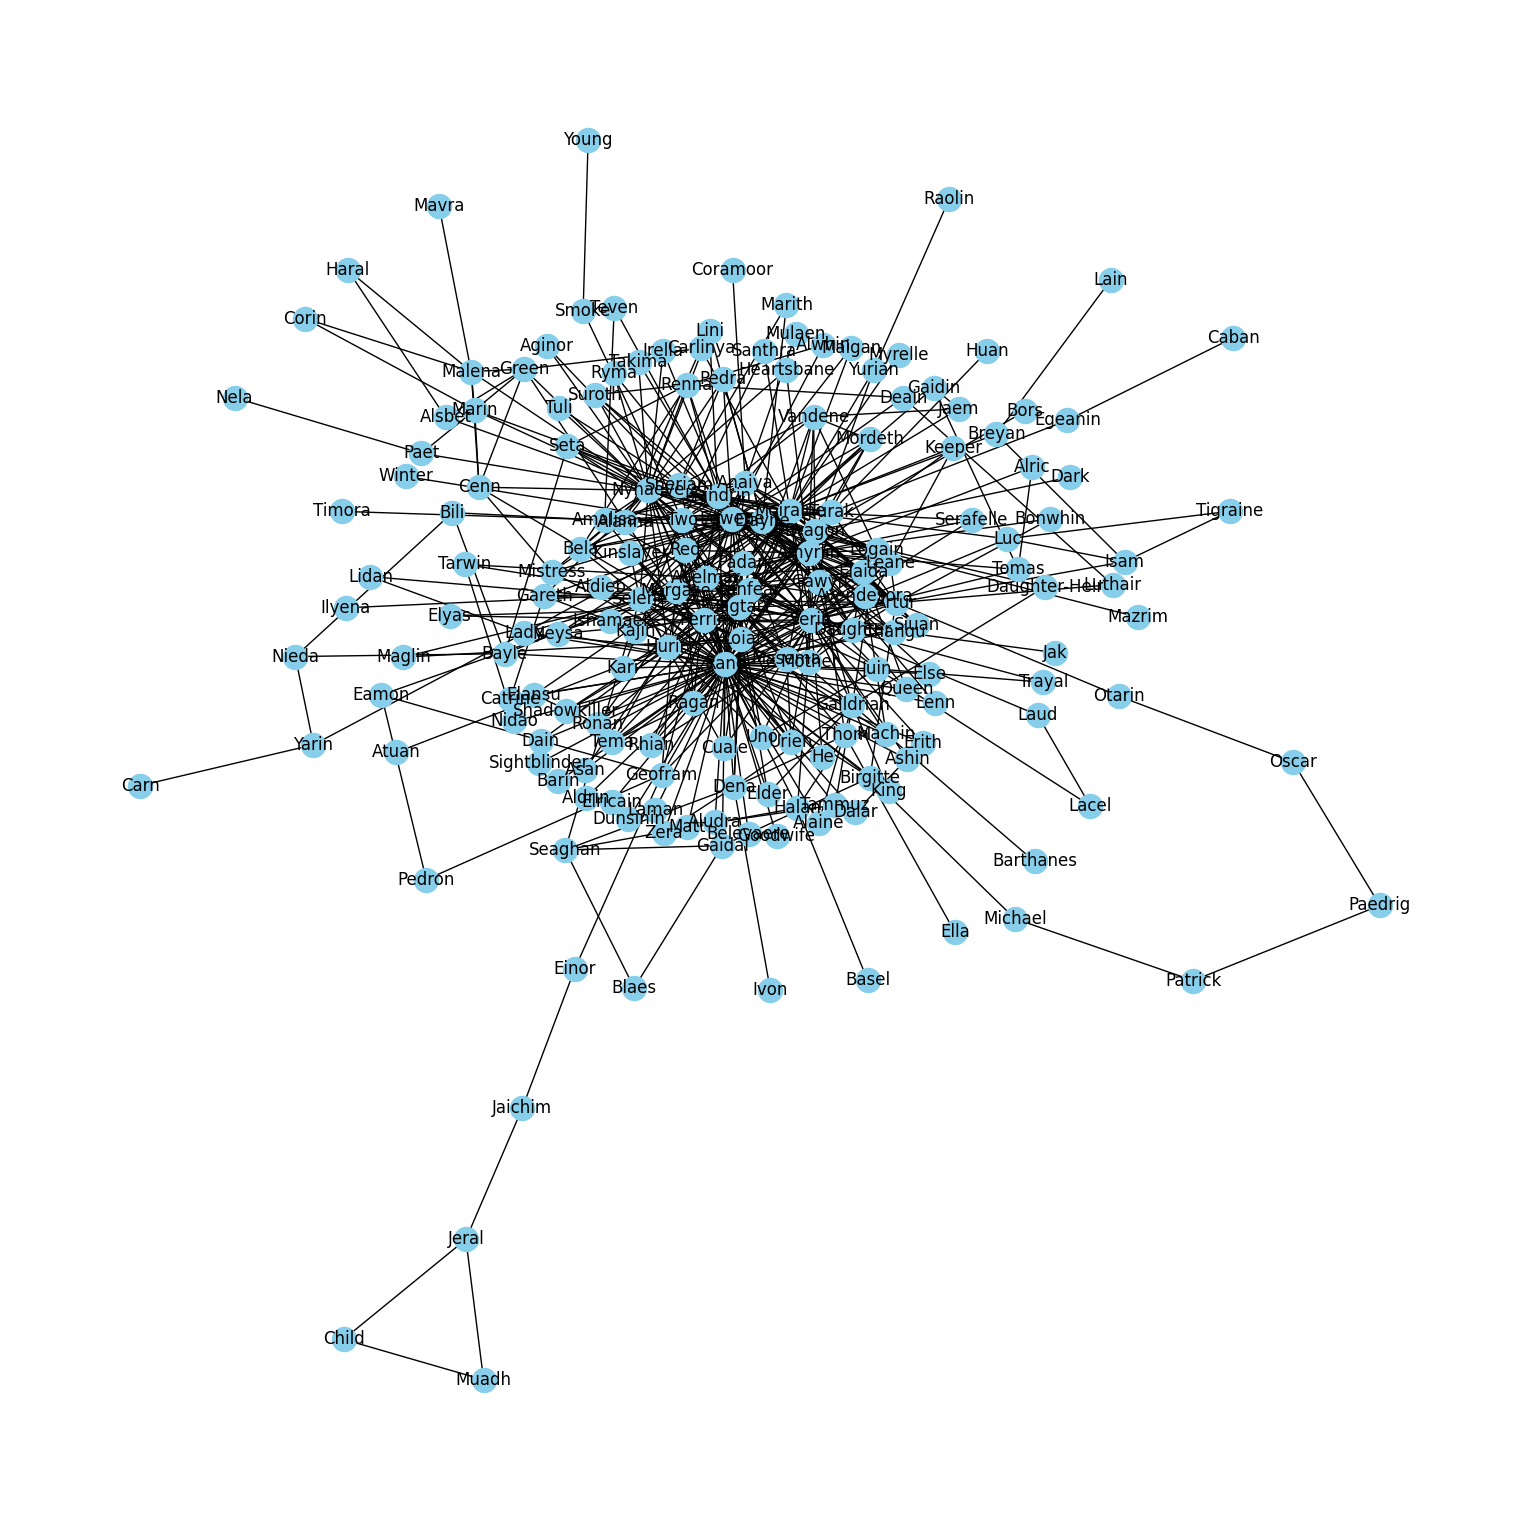

In [90]:
#Pyplot graph visualization
plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [91]:
#Pyvis graph visualization
import os
from pyvis.network import Network
net = Network(notebook=True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='remote')

#Include degree (amount of edges)
node_degree = dict(G.degree)
#Set up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
#Option to turn on/off physics
net.show_buttons(filter_=['physics'])

net.from_nx(G)
net.show("wheel_of_time.html")
os.system(f'start {"wheel_of_time.html"}')

wheel_of_time.html


0

Defining Most Important Characters

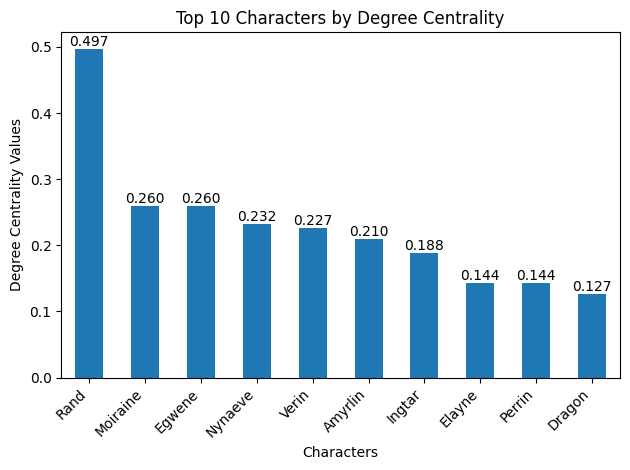

In [92]:
#Looking at degree centrality (the nodes with most edges)
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
top_degree_df = degree_df.sort_values('centrality', ascending=False)[0:10]

# Create the bar plot
ax = top_degree_df.plot(kind='bar', legend=False)
plt.title('Top 10 Characters by Degree Centrality')
plt.ylabel('Degree Centrality Values')
plt.xlabel('Characters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Include the degree_dict values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.show()

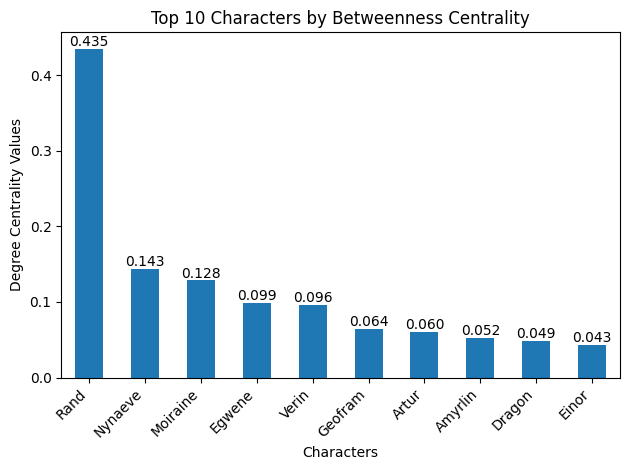

In [93]:
#Looking at betweenness centrality (number of times a node lies on the shortest path between all other pairs of nodes)
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df = betweenness_df.sort_values('centrality', ascending=False)[0:10]

# Create the bar plot
ax = betweenness_df.plot(kind='bar', legend=False)
plt.title('Top 10 Characters by Betweenness Centrality')
plt.ylabel('Degree Centrality Values')
plt.xlabel('Characters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Include the between_dict values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.show()


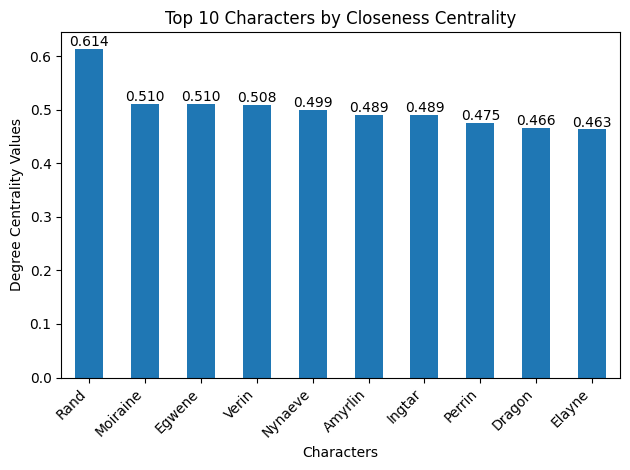

In [94]:
#Looking at closeness centrality (average shortest path distance from a node to all other nodes)
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df = closeness_df.sort_values('centrality', ascending=False)[0:10]

# Create the bar plot
ax = closeness_df.plot(kind='bar', legend=False)
plt.title('Top 10 Characters by Closeness Centrality')
plt.ylabel('Degree Centrality Values')
plt.xlabel('Characters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Include the closeness_dict values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.show()

Community Detection


In [95]:
#Louvain community detection algorithm
import community as community_louvain
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')

In [96]:
com_net = Network(notebook=True, width="1000px", height='700px', bgcolor='#222222', font_color='white')
#Option to turn on/off physics
com_net.show_buttons(filter_=['physics'])
com_net.from_nx(G)
com_net.show("wheel_of_time_communities.html")
os.system(f'start {"wheel_of_time_communities.html"}')

wheel_of_time_communities.html


0

Characters Importance Over Time

Analyzing: data\Robert Jordan - The Wheel of Time 01 - Eye of the world.txt
Analyzing: data\Robert Jordan - The Wheel of Time 02 - The Great Hunt.txt
Analyzing: data\Robert Jordan - The Wheel of Time 03 - The Dragon Reborn.txt


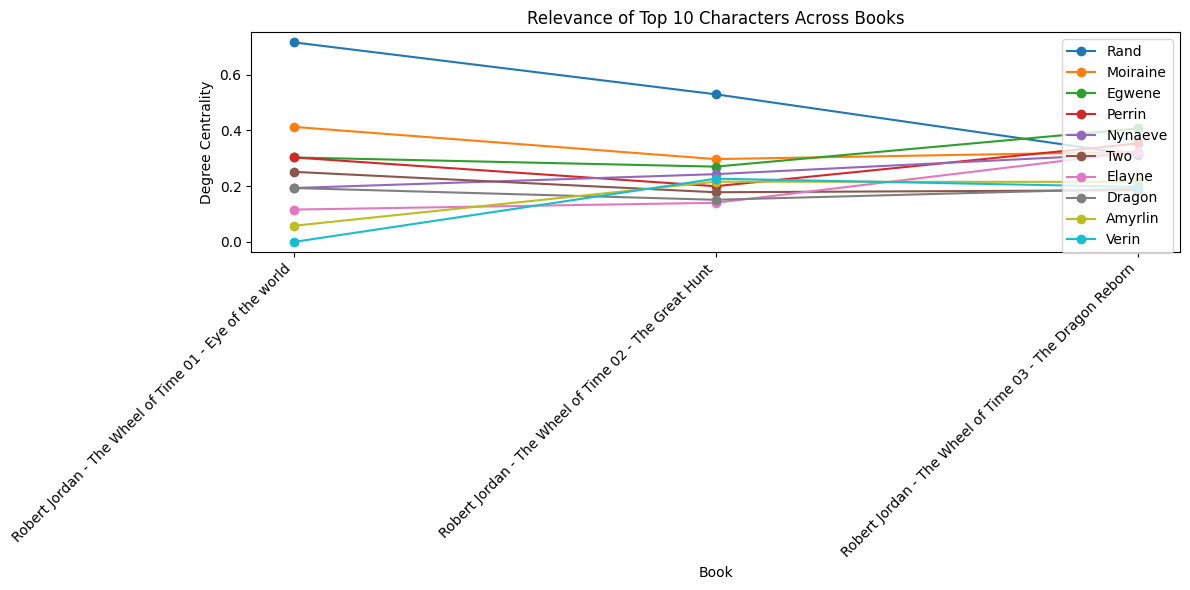

In [ ]:
def analyze_book(book_path, character_df):
    print(f"Analyzing: {book_path}")
    with open(book_path, encoding='latin1') as f:
        book_txt = f.read()
    book_doc = NER(book_txt)

    sent_entity_df = []
    for sent in book_doc.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})
    sent_entity_df = pd.DataFrame(sent_entity_df)

    def filter_characters(ent_list, character_df):
        return [ent for ent in ent_list
                if ent in list(character_df.character)
                or ent in list(character_df.character_firstname)]

    sent_entity_df['entities'] = sent_entity_df['entities'].apply(lambda x: filter_characters(x, character_df))
    sent_entity_df = sent_entity_df[sent_entity_df['entities'].apply(lambda x: x != [])]
    sent_entity_df['entities'] = sent_entity_df['entities'].apply(lambda x: [item.split()[0] for item in x])

    relationships = []
    window_size = 5
    for i_idx in range(len(sent_entity_df)):
        start_i = sent_entity_df.index[i_idx]
        end_i_idx = min(i_idx + window_size, len(sent_entity_df) - 1)
        end_i = sent_entity_df.index[end_i_idx]
        char_list = sum((sent_entity_df.loc[start_i: end_i].entities), [])
        char_unique = [char_list[i] for i in range(len(char_list))
                       if (i == 0) or char_list[i] != char_list[i - 1]]
        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})

    relationships_df = pd.DataFrame(relationships)
    relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns=relationships_df.columns)
    relationships_df["value"] = 1
    relationships_df = relationships_df.groupby(["source", "target"], sort=False, as_index=False).sum()

    G = nx.from_pandas_edgelist(relationships_df, source='source', target='target',
                                edge_attr='value', create_using=nx.Graph())

    degree_centrality = nx.degree_centrality(G)
    return degree_centrality

#Load and analyze all books
books_data = {}
books = sorted([b for b in os.scandir('data') if '.txt' in b.name], key=lambda x: x.name) # Sort books by name if order matters

for book in books:
    centrality_scores = analyze_book(os.path.join('data', book.name), character_df)
    book_title = book.name.replace(".txt", "")
    books_data[book_title] = centrality_scores

#PLot
relevance_df = pd.DataFrame.from_dict(books_data).fillna(0)

# Identify the most relevant characters overall
all_characters = set(relevance_df.index)
overall_relevance = relevance_df.sum(axis=1).sort_values(ascending=False)
top_n = 10
top_characters = overall_relevance.head(top_n).index.tolist()

# Plot relevance of top characters across books
plt.figure(figsize=(12, 6))
for character in top_characters:
    if character in relevance_df.index:
        plt.plot(relevance_df.columns, relevance_df.loc[character], label=character, marker='o')

plt.xlabel("Book")
plt.ylabel("Degree Centrality")
plt.title(f"Relevance of Top {top_n} Characters Across The Three Books")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()